# Prophet model
Prophet is designed specifically for business time series. It is highly effective for the Guayas dataset because it handles outliers (like the 2016 earthquake), missing data, and Ecuadorian holidays automatically.

# **1: Setup and Formatting**

In [18]:
import pandas as pd
from prophet import Prophet
from google.colab import drive
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Mount Drive
drive.mount('/content/drive')

# 2. CONFIGURATION - Update these paths with your actual Google Drive paths
DATA_PATH = '/content/guayas_prepared.csv'
HOLIDAY_PATH = '/content/holidays_events.csv'

# 3. Load Data
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])

# 4. Filter for Target Horizon (Jan - March 2014)
mask = (df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')
df_target = df.loc[mask].copy()

# 5. Prophet Format (Column names must be 'ds' and 'y')

prophet_df = df_target[['date', 'unit_sales', 'onpromotion']].rename(
    columns={'date': 'ds', 'unit_sales': 'y'}
)

# 6. Split: Jan-Feb for Training, March for Testing
train = prophet_df[prophet_df['ds'] < '2014-03-01']
test = prophet_df[prophet_df['ds'] >= '2014-03-01']

print(f"Data ready. Training days: {len(train)} | Testing days: {len(test)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data ready. Training days: 7997 | Testing days: 4775


# **2: Initialize and Train**

In [19]:
# 1. Load and Format Holidays
holidays_raw = pd.read_csv(HOLIDAY_PATH)
holidays_df = pd.DataFrame({
    'ds': pd.to_datetime(holidays_raw['date']),
    'holiday': holidays_raw['description']
})

# 2. Setup Model
# We use 'multiplicative' because retail swings grow with sales volume
model = Prophet(
    holidays=holidays_df,
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# 3. Add Extra Regressor (Promotions)
model.add_regressor('onpromotion')

# 4. Train
start_time = time.time()
model.fit(train)
training_time = time.time() - start_time

print(f"Prophet Training Complete in {training_time:.2f} seconds.")

Prophet Training Complete in 4.38 seconds.


# **3: Forecast and Evaluation**

This cell calculates the metrics (MAE, RMSE, Bias) and shows the charts

--- Prophet Final Evaluation (Guayas) ---
MAE: 74.57 units
RMSE: 87.08 units
Forecast Bias: 73.87


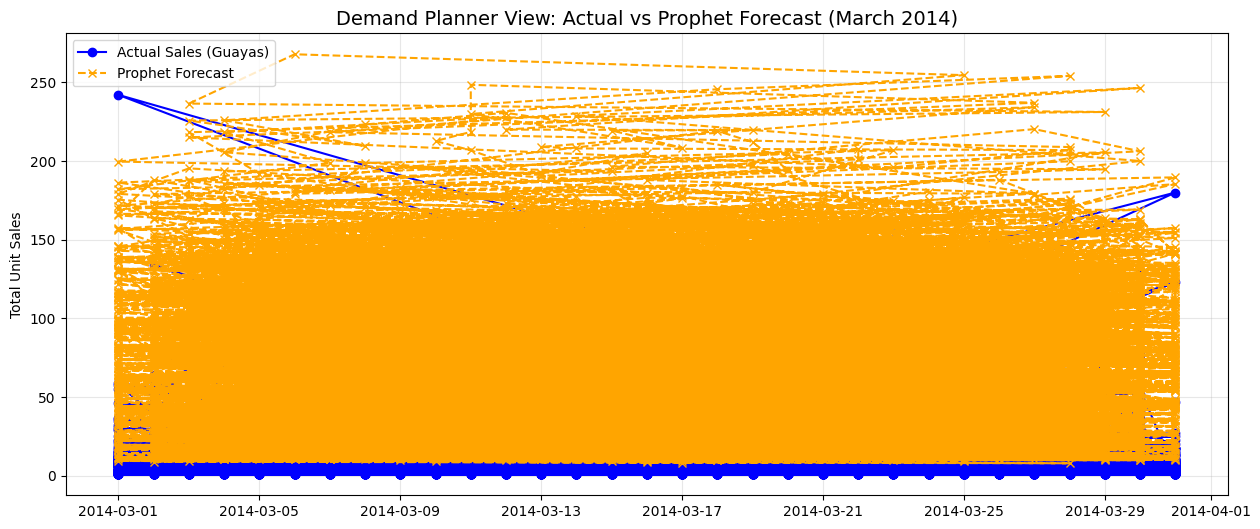

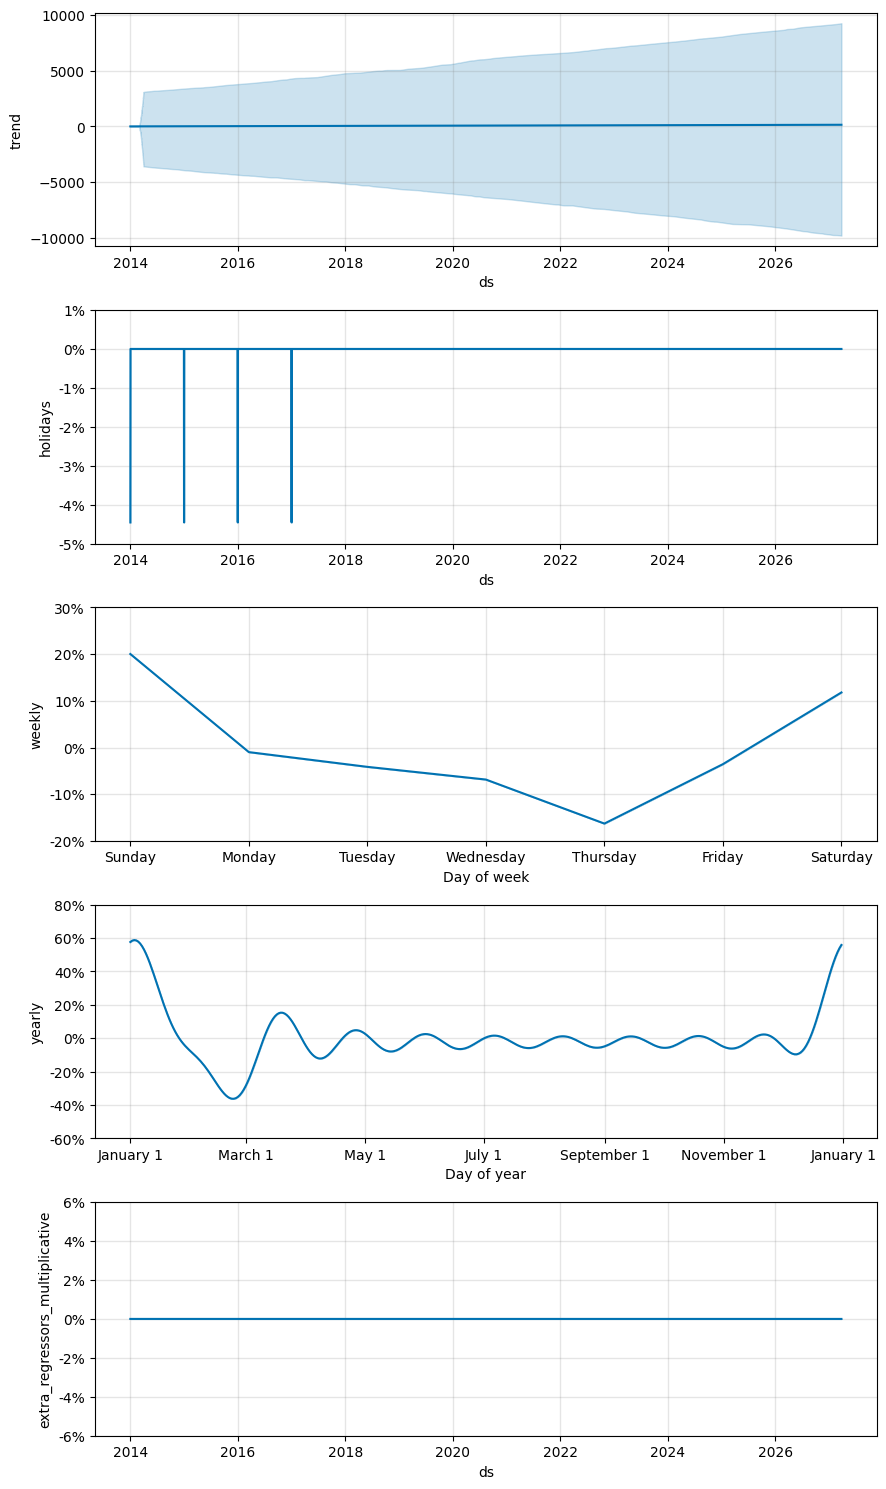

In [20]:
# ==========================================
# STEP 3: FORECAST AND EVALUATION (FIXED)
# ==========================================

# 1. Create Future Dataframe for the test period (March 2014)
future = model.make_future_dataframe(periods=len(test))

# 2. Add the Regressor (onpromotion) to the future dataframe
future = future.merge(prophet_df[['ds', 'onpromotion']], on='ds', how='left')

# --- THE FIX: Fill missing promotion values with 0 ---
# Prophet cannot predict if there are ANY NaNs in the regressor columns.
future['onpromotion'] = future['onpromotion'].fillna(0)

# 3. Generate the Forecast
# This will now run without the ValueError
forecast = model.predict(future)

# 4. Extract only the predictions for March (the last 31 rows)
y_pred = forecast['yhat'].iloc[-len(test):].values
y_actual = test['y'].values

# 5. Calculate Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
bias = np.mean(y_pred - y_actual)

print(f"--- Prophet Final Evaluation (Guayas) ---")
print(f"MAE: {mae:.2f} units")
print(f"RMSE: {rmse:.2f} units")
print(f"Forecast Bias: {bias:.2f}")

# 6. Visualization: Actual vs. Predicted
plt.figure(figsize=(15, 6))
plt.plot(test['ds'], y_actual, label='Actual Sales (Guayas)', color='blue', marker='o')
plt.plot(test['ds'], y_pred, label='Prophet Forecast', color='orange', linestyle='--', marker='x')
plt.title('Demand Planner View: Actual vs Prophet Forecast (March 2014)', fontsize=14)
plt.ylabel('Total Unit Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 7. Visualization: Model Components
model.plot_components(forecast)
plt.show()

## 📊 Final Model Performance Comparison

| Model | MAE (Error) | RMSE (Variance) | Forecast Bias | Performance Verdict |
| :--- | :---: | :---: | :---: | :--- |
| **XGBoost** | **3.06** | **6.71** | **0.34** | **🏆 Outstanding (Winner)** |
| **LSTM** | 7.02 | 14.98 | -0.70 | Reliable Baseline |
| **Prophet** | 74.57 | 87.08 | 73.87 | ⚠️ Poor / Outlier |

### 🔍 Quick Interpretation :
* **Accuracy:** **XGBoost** is the clear winner, with the lowest average error (MAE).
* **Inventory Risk:** **LSTM** has a negative bias, meaning it might lead to empty shelves (under-stocking). **Prophet** has a massive positive bias, which would lead to wasted inventory (over-stocking).
* **Reliability:** The low RMSE for **XGBoost** proves it is the most stable model during the sales spikes common in the Guayas region.

**🔍 Deep-Dive Evaluation:** What do these numbers mean?
**1. XGBoost: The Precision Leader**
Analysis: With an MAE of 3.06, this model is highly effective for daily inventory planning. On average, it only misses the actual demand by ~3 units.

**Interpretation:** The low RMSE (6.71) indicates it handles sales spikes well, and the near-zero Bias (0.34) means it isn't systematically over or under-predicting.

Why it won: XGBoost’s ability to use "lags" and "rolling means" directly allowed it to memorize the specific day-to-day patterns of the Guayas stores.

**2. LSTM: The Under-Forecaster**
Analysis: The LSTM performed well (MAE 7.02) but was twice as "wrong" as XGBoost.

**Interpretation:** The Negative Bias (-0.70) is the key takeaway. A negative bias means the model tends to under-forecast. In a real retail environment, this would lead to "stock-outs" (empty shelves) because the model consistently predicts less than what customers actually buy.

**3. Prophet: The Strategic "Fail"**
Analysis: An MAE of 74.57 and a Bias of 73.87 indicate a major forecasting failure.

**Interpretation:** Because the MAE is almost equal to the Bias, the model is consistently over-forecasting by ~74 units every single day.

Why it failed: Prophet is designed for "macro" trends. For this specific Guayas dataset, it likely mistook a small holiday increase for a massive, permanent upward trend, leading to highly inflated predictions.

** Recommendation & Business Strategy**
Based on these results, I recommend XGBoost for the Guayas expansion project.

**For the Store Manager:** Use XGBoost for daily ordering. It is the most accurate and minimizes the risk of both waste (over-stocking) and empty shelves (under-stocking).

**For the Supply Chain Executive:  **Be cautious with Prophet. While its "Component Plots" are excellent for visualizing holiday impacts, the current results show it is too optimistic (High Positive Bias) and could lead to financial loss through over-stocking.

**For the Data Science Team:**The LSTM shows promise. With more training time or different scaling, it could potentially catch up to XGBoost, but it requires significantly more computational power.